In [1]:
import obspy, glob
import numpy as np
import numpy.matlib
import pandas as pd
from obspy import Trace, UTCDateTime, Stream
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
from scipy import signal, ndimage
from scipy.io.wavfile import read, write
import cv2
from datetime import datetime, date, timedelta
import warnings
from collections import defaultdict

warnings.filterwarnings('ignore')

In [2]:
path = '/Volumes/Data/Soundscape/03_TaoYuan/2023/20230608-20230623/wav'

S = -176.1 # end to end 
P_ref = 1 # water: 1 uPa
interval = 10 # sec
fmin = 200 # Hz
fmax = 2000 # Hz

In [3]:
def calib(data, S):
    audio_data = data.astype(np.float32, order='C') / 32768.0
    calib_data = audio_data / ((10)**(S/20))
    return calib_data # uPa

          
def spectrogram(data, sampling_frequency, window='hann', fmin=200, fmax=2000):
    f, t, spect = signal.spectrogram(
                    data,
                    fs=sampling_frequency,
                    window=window,
                    nperseg=2400,
                    noverlap=2400*0.9,
                    nfft=2**16,
                    scaling="spectrum" )
    
    fmin_idx = np.where(f <= fmin)[0][-1]+1#, f[274]
    fmax_idx = np.where(f <= fmax)[0][-1]-1#, f[2729]
    f = f[fmin_idx:fmax_idx]
    spect = spect[fmin_idx:fmax_idx,:]
    return f, t, spect

def denoise(spect, duration=1, time_resolution=0.033):
    
    Smed = ndimage.median_filter(
            spect,
            (1, round(duration / time_resolution)) )
    spect = spect - Smed
    spect[spect < 0] = 0  # floor
    return spect
def detect(t, f, spect, tr, starttime, kernel_duration=0.035, kernel_bandwidth=300, threshold_pct=90):
    f_res = f[1]-f[0]
    t_res = round(t[1]-t[0], 5)
    kernel_duration = max(round(kernel_duration/t_res), 1) #sec
    kernel_bandwidth = max(round(kernel_bandwidth/f_res), 1)

    Svar = ndimage.generic_filter(spect,
                                  calcVariance2D,
                                  (kernel_bandwidth, kernel_duration),
                                  mode='mirror')
    # binarization
    threshold = np.percentile(Svar, threshold_pct, interpolation='linear')
    Svar[Svar < threshold] = 0
    Svar[Svar > 0] = 1
    
    Svar_gray = cv2.normalize(src=Svar,
                              dst=None,
                              alpha=0,
                              beta=255,
                              norm_type=cv2.NORM_MINMAX,
                              dtype=cv2.CV_8UC1)
    (cnts, hierarchy) = cv2.findContours(Svar_gray.copy(),
                                              cv2.RETR_EXTERNAL,
                                              cv2.CHAIN_APPROX_SIMPLE)   
    cnts_sorted = sorted(list(cnts),key=lambda d: d[0][0][0])
    # loop over the contours
    isdetec = False
    t1 = []; t2 = []
    fmin = []; fmax = []
    
    for c in cnts_sorted:
        # Compute the bounding box for the contour
        (x, y, w, h) = cv2.boundingRect(c)
        # if the contour is too small, ignore it
        if w < kernel_duration or h < kernel_bandwidth:
            continue

        else:
            isdetec = True
            if len(t1)>0 and t2[-1]>=x>=t1[-1]:
                _fmin = fmin[-1]; _fmax = fmax[-1]
                if y<_fmin :
                    fmin[-1] = y
                if (y+h-1)>_fmax:
                    fmax[-1] = y+h-1
                continue
            else:
                t1.append(x); t2.append(x+w-1) # box coord
                fmin.append(y); fmax.append(y+h-1)   
    
    detec = {} 
    detec['time_min_offset'] = [t[0]+_t*t_res for _t in t1]
    detec['time_max_offset'] = [t[0]+_t*t_res for _t in t2]
    detec['frequency_min'] = [f[_f] for _f in fmin]
    detec['frequency_max'] = [f[_f] for _f in fmax]
    detec['duration'] = np.array(detec['time_max_offset']) - np.array(detec['time_min_offset'])
    detec['time_min_date'] = [starttime+_t*t_res+t[0] for _t in t1] 
    detec['time_max_date'] = [starttime+_t*t_res+t[0] for _t in t2]
    detec['SPLpp'] = [ SPL_PP(tr, t1, t2) for t1, t2 in zip(detec['time_min_date'], detec['time_max_date'])]
    detec = pd.DataFrame(detec)
    detec.sort_values('time_min_offset',
                       ascending=True,
                       inplace=True,
                       ignore_index=True )
    return Svar, detec

def calcVariance2D(buffer):
    """Calculate the 2D variance."""
    return np.var(buffer)
    # return np.median(buffer.ravel())
    # return np.mean(buffer.ravel())
    
def plot_annot(detectfile, ax, type='spectrogram'):
    if type == 'spectrogram':
        alpha = 0.7
        facecolor = "none"
        color='red'
        label='detected'
        line_width = 0.7
        for index, row in detectfile.iterrows():
            x = row["time_min_offset"]
            y = row["frequency_min"]
            width = row["duration"]
            height = row["frequency_max"] - row["frequency_min"]
            import matplotlib.patches as patches
            rect = patches.Rectangle((x, y), width, height, linewidth=line_width, edgecolor=color, facecolor=facecolor, alpha=alpha)
            ax.add_patch(rect)  
    elif type == 'waveform':
        alpha = 0.1
        facecolor = "red"
        color='none'
        label='detected'
        line_width = 0.5
        for index, row in detectfile.iterrows():
            x = row["time_min_offset"]
            y = min(ax.get_ylim())
            width = row["duration"]
            height = max(ax.get_ylim()) - min(ax.get_ylim())
            
            import matplotlib.patches as patches
            rect = patches.Rectangle((x, y), width, height, linewidth=line_width, edgecolor=color, facecolor=facecolor, alpha=alpha)
            ax.add_patch(rect)  
    return ax

def SPL_PP(tr, t1, t2):
    P_ref = 1
    tr_sound = tr.slice(t1, t2)
    p_peak = max(tr_sound.data)+abs(min(tr_sound.data))
    P_spl = 20*np.log10(p_peak/P_ref)
    return P_spl

In [4]:
df_min = {'Time':[],
         'Peak': [],
         'MaxSPL': [], 
         'SPLrms':[]}
for file in glob.glob(f'{path}/????.23061817*.wav'):
    print(file)
    rate, data_ = read(file) 
    data = calib(data_, S)
    
    filetime = file.rsplit('.')[1]
    tr = Trace()
    tr.data = data
    tr.stats.sampling_rate = rate
    if rate == 96000:
        tr.decimate(2, no_filter=True)
    
    tr.stats.starttime = UTCDateTime(2023, int(filetime[2:4]), int(filetime[4:6]), int(filetime[6:8]), int(filetime[8:10]), int(filetime[10:]))
    tr_bp = tr.copy()
    tr_bp.filter('bandpass', freqmin=fmin, freqmax=fmax, corners=6, zerophase=True)
    
#     total_min = int(tr.stats.endtime - tr.stats.starttime)/60
    

#     for mm in range(int(total_min)):
        
#         df_sec = {'Time':[],
#                  'Peak': [],
#                  'MaxSPL': []}
        
#         tr_cut = tr_bp.copy()
#         start = tr.stats.starttime + mm*60 
#         end = start + 60
#         tr_cut = tr_cut.slice(starttime=start, endtime=end)
        
#         p_rms = np.sqrt(np.mean(tr_cut.data**2))
#         P_spl = 20*np.log10(p_rms/P_ref)
        
#         for ss in range(60):
#             tr_cut = tr_bp.copy()
#             start = tr.stats.starttime + mm*60 + ss
#             end = start + 1 
#             tr_cut = tr_cut.slice(starttime=start, endtime=end)

#             findpeak, all_score, SPL_p2p = SPL(tr_cut)

#             df_sec['Time'].append(tr_cut.stats.starttime)
#             df_sec['Peak'].append(len(findpeak))
#             df_sec['MaxSPL'].append(max(SPL_p2p))
            
#         tr_time = tr_cut.stats.starttime
#         df_min['Time'].append(UTCDateTime(tr_time.year, tr_time.month, tr_time.day, tr_time.hour, tr_time.minute))
#         df_min['Peak'].append(sum(df_sec['Peak']))
#         df_min['MaxSPL'].append(max(df_sec['MaxSPL']))
#         df_min['SPLrms'].append(P_spl)
    
# df_min = pd.DataFrame(df_min)
        

/Volumes/Data/Soundscape/03_TaoYuan/2023/20230608-20230623/wav/6979.230618170002.wav


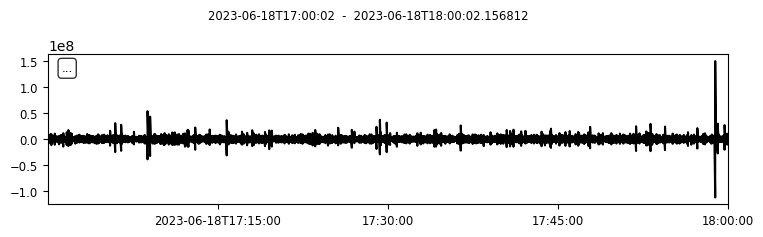

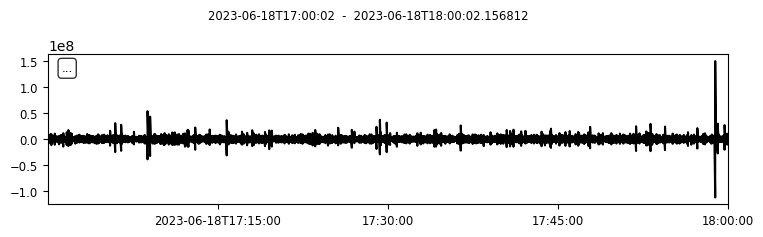

In [5]:
tr_bp.plot()

## for plotting 

In [ ]:
alldetect = pd.DataFrame()
plot = True

t0 = datetime.now()
total_sec = int(tr_bp.stats.endtime - tr_bp.stats.starttime)
for dt in np.arange(28*60+30, 29*60+30, interval):
    print(dt)
    tr_cut = tr_bp.copy() 
    start  = tr_bp.stats.starttime + dt
    end    = start + interval
    tr_cut = tr_cut.slice(starttime=start, endtime=end)
    tr_cut.data = tr_cut.data - np.mean(tr_cut.data)

    
    f, t, spect = spectrogram(tr_cut.data, tr_cut.stats.sampling_rate)
    spect_denoise = denoise(spect)
    print('--------------- Calculate detection.  ')
    Svar_, detec = detect(t, f, spect_denoise, tr_cut, starttime=tr_cut.stats.starttime, )
    alldetect = pd.concat([alldetect, detec])
    if plot:
        fig, ax = plt.subplots(3,1 ,figsize=(15,5), sharex=True)
        plt.rc('font', family='Helvetica')
        ax[0].plot(tr_cut.times(), tr_cut.data, 'k')
        ax[0].set_xlim(tr_cut.times()[0], tr_cut.times()[-1])
        ax[0].set_ylabel('Pressure ($\mu$Pa)')

        ax[1].pcolormesh(t, f, spect_denoise, cmap="binary",
                        vmin=np.percentile(spect_denoise, 80),
                        vmax=np.percentile(spect_denoise, 99.9),
                        shading="gouraud")
        ax[1].set_ylim(fmin, fmax)
        ax[1].set_ylabel('Frequency (Hz)')
        
        ax[2].pcolormesh(t, f, Svar_, cmap="binary")
        ax[2].set_ylim(fmin, fmax)
        ax[2].set_xlabel('Time (s)')
        ax[2].set_ylabel('Frequency (Hz)')
        print('--------------- Plot annot. ')
        ax[1] = plot_annot(detec, ax[1], type='spectrogram')
        ax[0] = plot_annot(detec, ax[0], type='waveform')

        ax[0].set_title(f'# of detection: {len(detec)}')
t1 = datetime.now()
print(f'calculating time {t1-t0}')

1710
--------------- Calculate detection.  
--------------- Plot annot. 
1720
--------------- Calculate detection.  
--------------- Plot annot. 
1730
--------------- Calculate detection.  
--------------- Plot annot. 
1740
--------------- Calculate detection.  
--------------- Plot annot. 
1750
--------------- Calculate detection.  
--------------- Plot annot. 
1760
--------------- Calculate detection.  
--------------- Plot annot. 
calculating time 0:06:18.446291


In [ ]:
# to dask 